# Cargar librerías

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report

from sklearn.cluster import DBSCAN

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

ModuleNotFoundError: No module named 'tensorflow'

# Cargar datos

In [6]:
# Configurar pandas para mostrar más columnas
pd.set_option('display.max_columns', 50)  
# Configurar la anchura máxima de la columna y la anchura máxima total de la visualización
pd.set_option('display.max_colwidth', 100)  # Aumenta o disminuye según la necesidad
pd.set_option('display.width', 1000)        # Ajusta a la anchura de tu pantalla o salida

data = pd.read_csv("../DATA/creditcardfraud_normalised.csv")
data[data.columns[:28]] = data[data.columns[:28]].astype("float32")

X = data.drop('class', axis=1) 
y = data['class']

In [7]:
print("Número de filas: ", data.shape[0])
print("Número de columnas: ", data.shape[1])
print("Número de valores faltantes totales: ", data.isnull().sum().sum())

Número de filas:  284807
Número de columnas:  30
Número de valores faltantes totales:  0


A pesar de tratarse de un problema de clasificación observamos un gran desbalanceo de clases, por lo que usar técnicas de aprendizaje supervisado no es la mejor opción como veremos más adelante

In [8]:
print("Total de transacciones fraudulentas: ", y.value_counts()[1])
print("Total de transacciones NO fraudulentas: ", y.value_counts()[0])

Total de transacciones fraudulentas:  492
Total de transacciones NO fraudulentas:  284315


Realizamos un muestreo aleatorio quitando transacciones fraudulentas, debido a la gran cantidad de datos que hay

In [11]:
from sklearn.utils import resample

# Dividir las clases
X_class_0 = X[y == 0]
X_class_1 = X[y == 1]

y_class_0 = y[y == 0]
y_class_1 = y[y == 1]

# Realizar el undersampling para la clase 0
X_class_0_undersampled, y_class_0_undersampled = resample(
    X_class_0, y_class_0, 
    n_samples=100000,  # Hacemos que la clase 0 tenga el mismo número que la clase 1
    random_state=42
)

# Concatenar las clases balanceadas
X = pd.concat([X_class_0_undersampled, X_class_1])
Y = pd.concat([y_class_0_undersampled, y_class_1])

# Verificar el nuevo balance
print(f'Total de transacciones fraudulentas: {Y.sum()}')
print(f'Total de transacciones NO fraudulentas: {len(Y) - Y.sum()}')


Total de transacciones fraudulentas: 492
Total de transacciones NO fraudulentas: 100000


In [12]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
122207,0.941236,0.778372,0.856368,0.225731,0.769191,0.258837,0.268256,0.788659,0.433676,0.486986,0.212236,0.737534,0.623062,0.644784,0.356710,0.475472,0.703195,0.633173,0.546839,0.580599,0.558287,0.472800,0.663870,0.298116,0.576042,0.416540,0.415276,0.313217,0.000582
147150,0.951110,0.769785,0.863621,0.204237,0.760269,0.262120,0.270463,0.780418,0.438716,0.514404,0.227019,0.705791,0.530015,0.624474,0.363616,0.397007,0.720907,0.734335,0.536354,0.575266,0.552320,0.469909,0.665396,0.371549,0.544556,0.320234,0.413923,0.310971,0.004817
132194,0.955935,0.756950,0.852728,0.101497,0.773407,0.302378,0.258537,0.794713,0.409751,0.526589,0.235258,0.659523,0.468636,0.606847,0.282871,0.446667,0.726817,0.692321,0.541766,0.578630,0.557788,0.503135,0.664046,0.513985,0.562755,0.357841,0.416854,0.311533,0.000778
259649,0.962653,0.769620,0.854322,0.242134,0.763896,0.268731,0.262949,0.778549,0.477118,0.497479,0.333008,0.756964,0.510664,0.643308,0.315269,0.453759,0.711418,0.705402,0.575878,0.579370,0.578892,0.545636,0.662153,0.493398,0.622228,0.414850,0.420642,0.318341,0.001555
120126,0.933864,0.780956,0.853178,0.229952,0.767437,0.255313,0.268096,0.789262,0.445816,0.491189,0.278398,0.726371,0.513545,0.634834,0.375040,0.463954,0.733212,0.602496,0.464698,0.578560,0.559204,0.487657,0.667005,0.387457,0.561096,0.411176,0.415898,0.315319,0.000194


In [13]:
X.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000,100492.000000
mean,0.958049,0.767416,0.836996,0.252424,0.765624,0.262970,0.265271,0.785370,0.462434,0.508398,0.286060,0.703322,0.448463,0.645376,0.336314,0.448978,0.730457,0.652854,0.563336,0.580284,0.561520,0.510044,0.665408,0.382226,0.577990,0.425129,0.416545,0.313119,0.003460
std,0.034281,0.017836,0.028009,0.063945,0.009533,0.013426,0.008086,0.013386,0.038531,0.024306,0.062584,0.041047,0.077164,0.035676,0.068706,0.029623,0.029270,0.058939,0.063758,0.008186,0.012497,0.034127,0.009194,0.081632,0.029299,0.078627,0.007508,0.007122,0.009538
min,0.000000,0.000000,0.286129,0.003660,0.481978,0.000000,0.000000,0.241658,0.000000,0.000000,0.020434,0.000000,0.150397,0.000000,0.000000,0.000000,0.000000,0.000000,0.178111,0.282032,0.193973,0.095452,0.268156,0.001587,0.157152,0.122380,0.234780,0.117947,0.000000
25%,0.942602,0.761005,0.821828,0.214466,0.761034,0.255236,0.261972,0.783120,0.440373,0.497514,0.240000,0.688572,0.398261,0.631641,0.292613,0.434399,0.716869,0.619015,0.527490,0.577999,0.557793,0.484825,0.663025,0.334578,0.560098,0.371749,0.415208,0.312042,0.000210
50%,0.958555,0.768025,0.840449,0.251274,0.765339,0.260212,0.265605,0.785608,0.460817,0.506780,0.283379,0.709245,0.447349,0.647777,0.340017,0.451420,0.729043,0.652780,0.563582,0.579610,0.560991,0.510383,0.665257,0.387722,0.578968,0.416312,0.416542,0.313351,0.000851
75%,0.980671,0.775749,0.855191,0.285085,0.769822,0.267013,0.268836,0.788905,0.483093,0.518034,0.329901,0.727371,0.499788,0.662650,0.385058,0.465994,0.742595,0.687706,0.599493,0.581698,0.564521,0.534847,0.667636,0.441487,0.597772,0.464281,0.418211,0.314722,0.003003
max,1.000000,1.000000,0.907939,0.982972,1.000000,0.489531,0.490017,1.000000,0.782197,0.825930,1.000000,0.866942,0.793984,0.904692,0.768760,0.712984,0.998650,0.932144,1.000000,0.859628,1.000000,0.900117,0.947644,0.918488,0.888044,0.934979,0.622051,1.000000,0.502544


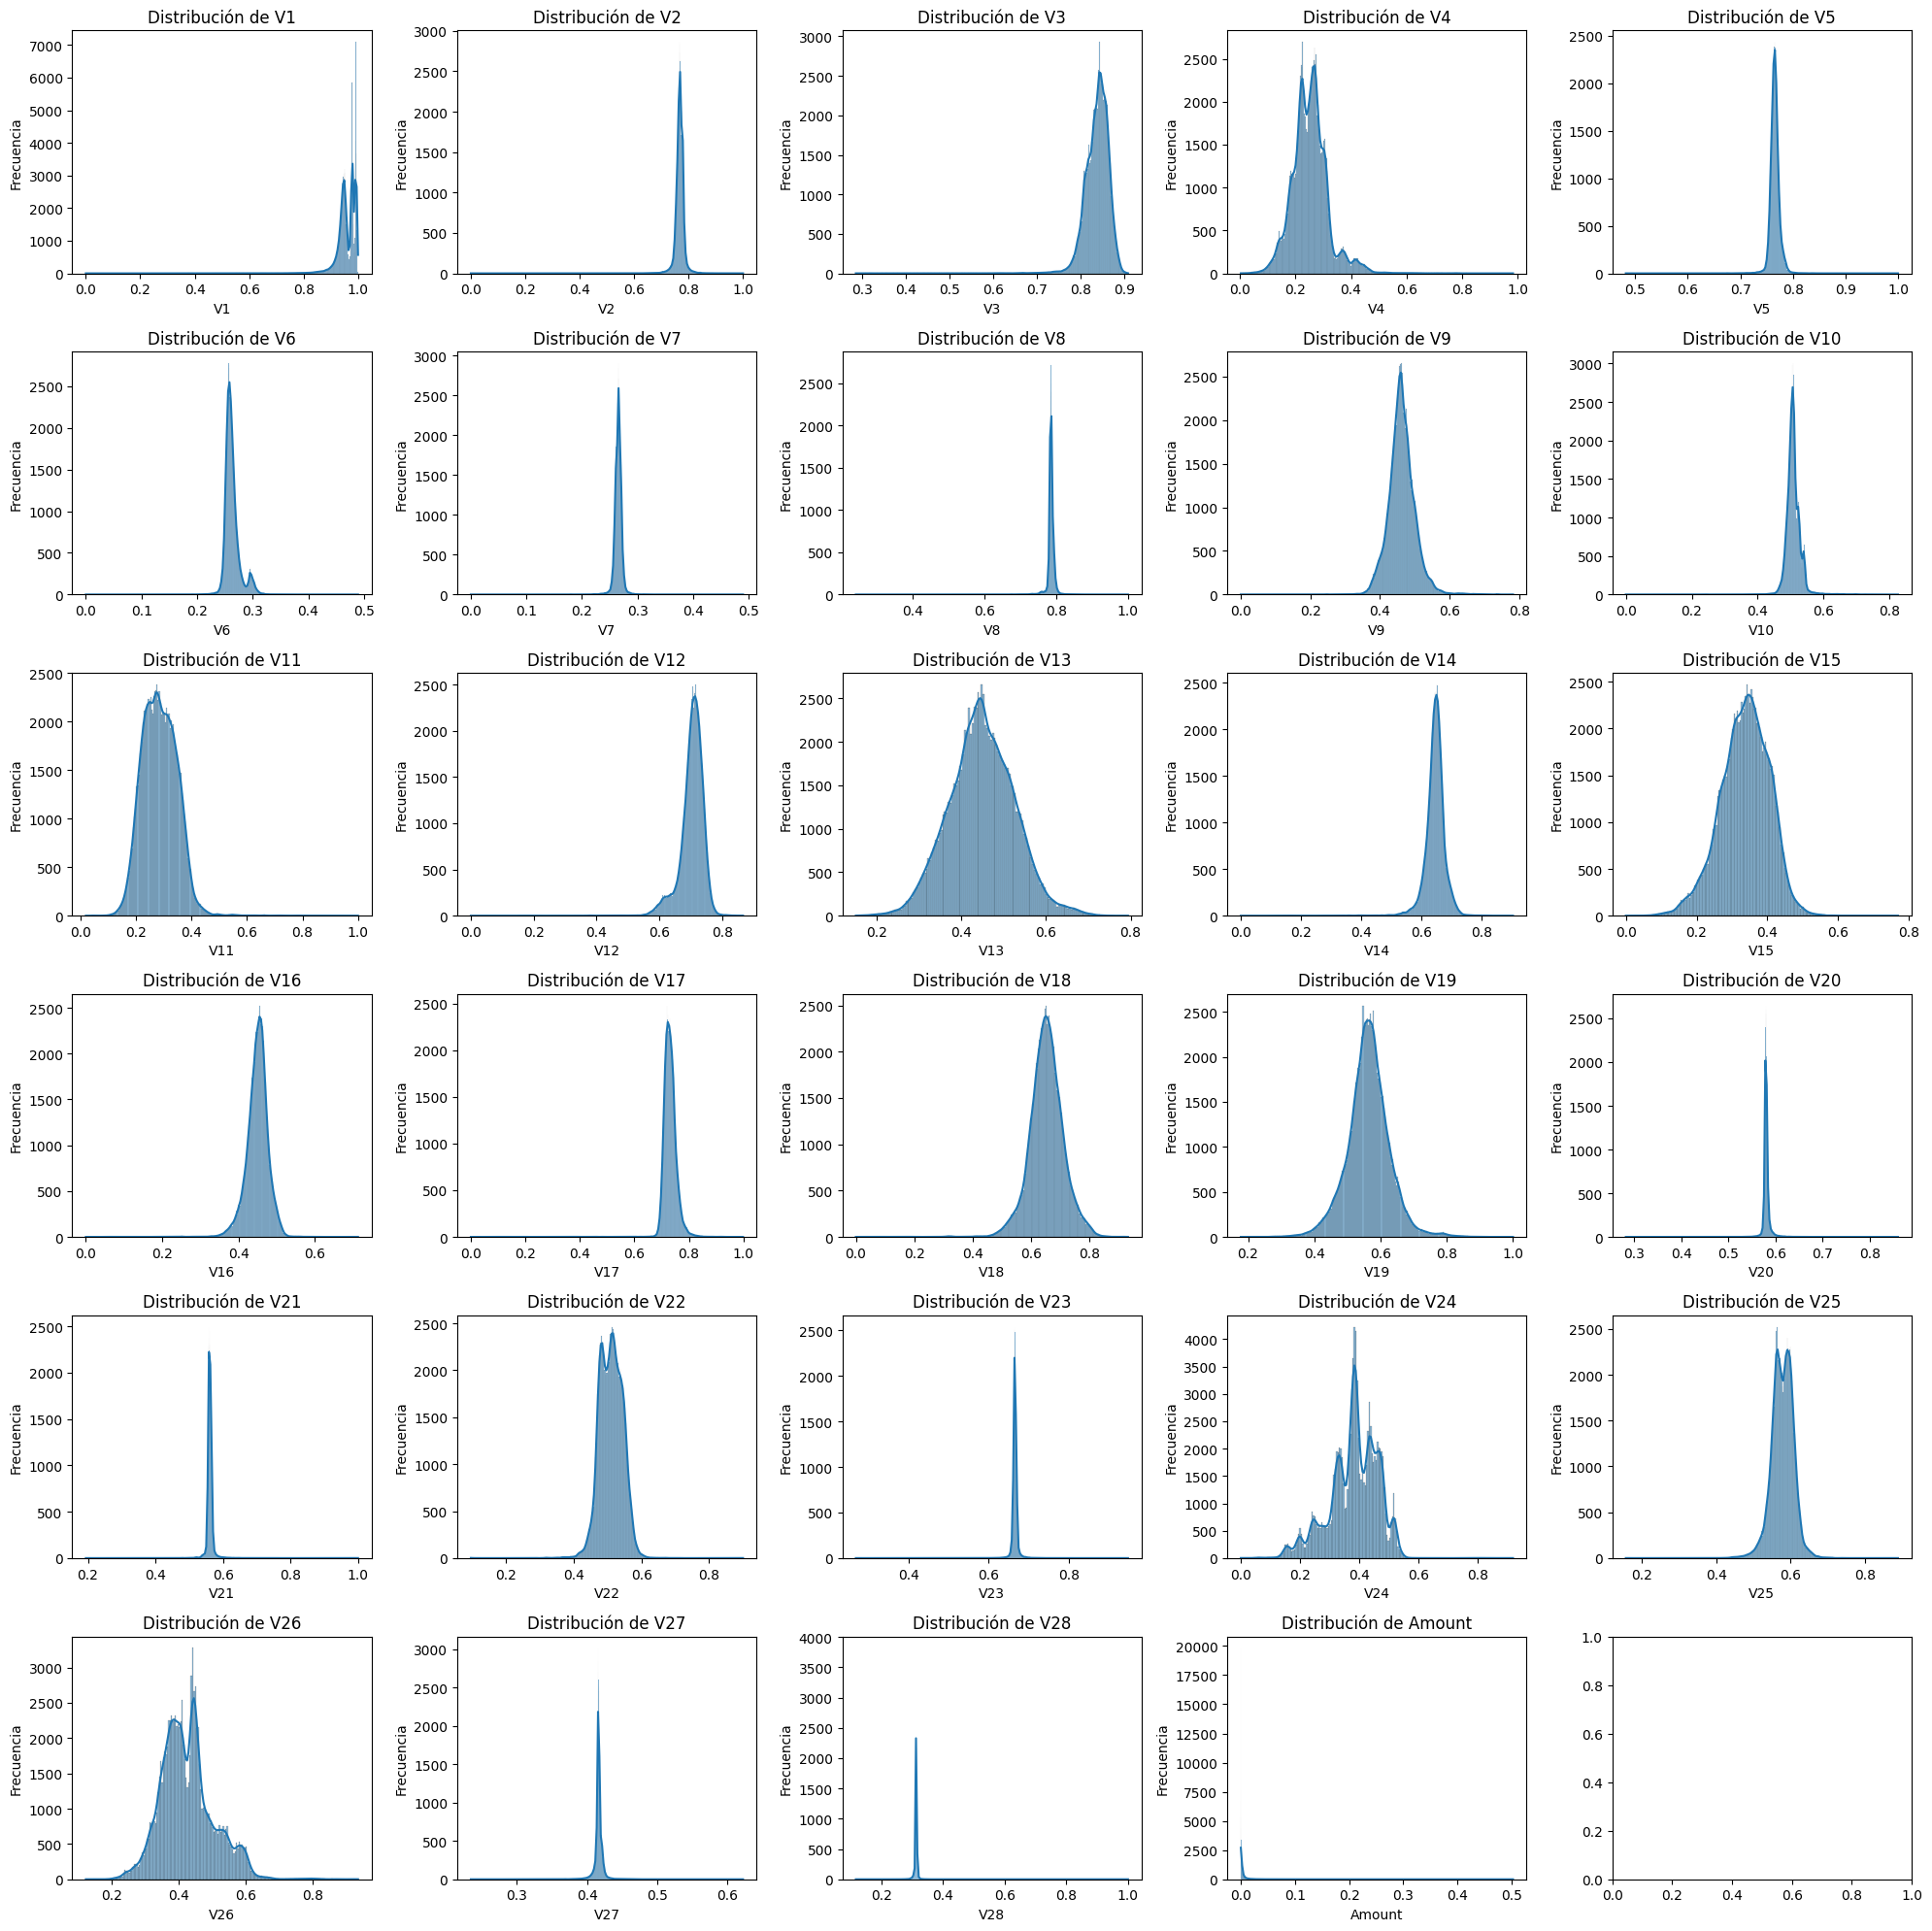

In [16]:
# Crear una figura con subgráficos
fig, axes = plt.subplots(6, 5, figsize=(20, 20))  # Ajusta el tamaño como necesario

# Aplanar la matriz de ejes para facilitar la iteración si hay más de una fila
axes = axes.flatten()

# Iterar a través de todas las columnas del DataFrame y crear un gráfico para cada una
for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')

# Ajustar la visualización y mostrar el gráfico
plt.tight_layout()
plt.show()

Observamos que normalizar los datos no es la mejor opción, ya que la mayoría de variables no siguen una distribución normal

# Separar en entrenamiento, validación y test

In [9]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle = True)
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

print("Dimensión de X_train", X_train.shape)
print("Dimensión de X_val", X_val.shape)
print("Dimensión de X_test", X_test.shape)
print("\n")
print("Dimensión de Y_train", Y_train.shape)
print("Dimensión de Y_val", Y_val.shape)
print("Dimensión de Y_test", Y_test.shape)

Dimensión de X_train (227845, 29)
Dimensión de X_val (56962, 29)
Dimensión de X_test (28481, 29)


Dimensión de Y_train (227845,)
Dimensión de Y_val (56962,)
Dimensión de Y_test (28481,)


# Selección de características


## INFORMACIÓN MUTUA

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from joblib import Parallel, delayed

# Supongamos que tienes un DataFrame df con todas las columnas numéricas
columns = X_train.columns
n = len(columns)

# Función para calcular la información mutua entre dos columnas
def calculate_mi(i, j):
    X = data.iloc[:, i].values.reshape(-1, 1)
    Y = data.iloc[:, j].values
    return mutual_info_regression(X, Y, discrete_features=False)[0]

# Generar combinaciones de índices para las columnas
indices = [(i, j) for i in range(n) for j in range(i+1, n)]

# Paralelizar el cálculo para cada combinación de columnas
results = Parallel(n_jobs=-1)(
    delayed(calculate_mi)(i, j) for i, j in indices
)

# Reconstruir la matriz de información mutua
mutual_info_matrix = np.zeros((n, n))
for idx, (i, j) in enumerate(indices):
    mutual_info_matrix[i, j] = results[idx]
    mutual_info_matrix[j, i] = results[idx] 

# Convertir la matriz a un DataFrame para mayor claridad
mutual_info_df = pd.DataFrame(mutual_info_matrix, index=columns, columns=columns)


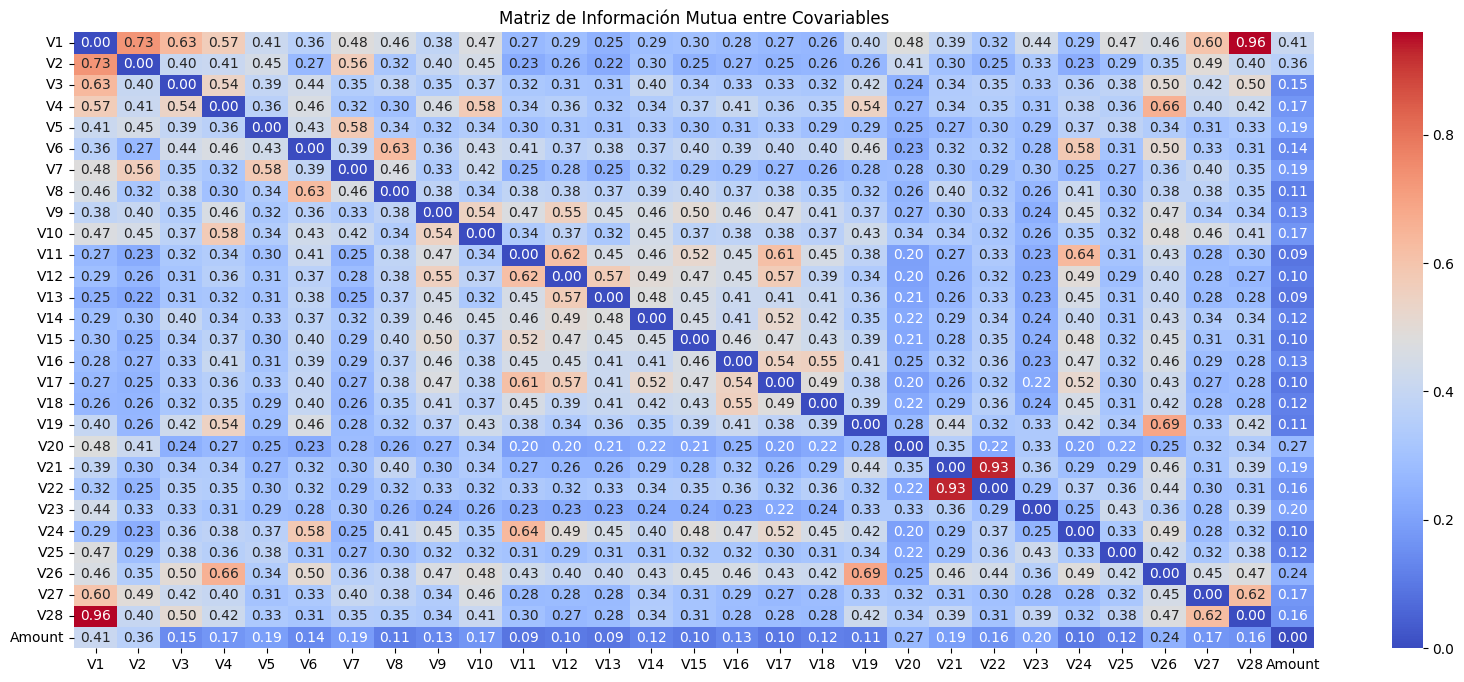

In [11]:
plt.figure(figsize=(20, 8))
sns.heatmap(mutual_info_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Información Mutua entre Covariables")
plt.show()

In [12]:
#seleccionar columnas que no tienen un valor de información mutua superior a 0.85
variables_MI = mutual_info_df.columns[(mutual_info_df <= 0.85).all(axis=0)]

#aplicar a train y test
X_train_MI = X_train[variables_MI]
X_test_MI = X_test[variables_MI]

## FACTOR DE INFLACIÓN DE LA VARIANZA
El factor de inflación de la varianza mide las relaciones entre todos los grupos de variables, de forma que puede capturar las relaciones lineales existentes entre una variable independiente y el resto de las variables independientes en un modelo

In [13]:
# Añadir una constante (necesaria para el cálculo del VIF)
X_const = add_constant(pd.DataFrame(X_train))

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(X_train.shape[1])]

print(vif_data[vif_data["VIF"] < 5])

   Variable       VIF
0        V1  1.600222
1        V2  4.313549
2        V3  1.513683
3        V4  1.114543
4        V5  2.748387
5        V6  1.540979
6        V7  2.851220
7        V8  1.119495
8        V9  1.023200
9       V10  1.120161
10      V11  1.000055
11      V12  1.001183
12      V13  1.000389
13      V14  1.013654
14      V15  1.000162
15      V16  1.000361
16      V17  1.000643
17      V18  1.014812
18      V19  1.036625
19      V20  2.374401
20      V21  1.130564
21      V22  1.048633
22      V23  1.146564
23      V24  1.000388
24      V25  1.026765
25      V26  1.000136
26      V27  1.011660
27      V28  1.001426


In [14]:
#seleccionar todas variables excepto Amount
vars_vif = vif_data[vif_data["VIF"] < 5]["Variable"]

#aplicar a train test
X_train_vif = X_train[vars_vif]
X_test_vif = X_train[vars_vif]

## PCA

In [10]:
# Ajustar PCA sin especificar el número de componentes
pca = PCA()
pca.fit(X_train)

# Calcular la varianza explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

/var/folders/l6/l10s0t8n3cd4ghd9mjhdlltw0000gn/T/ipykernel_76013/2954752168.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


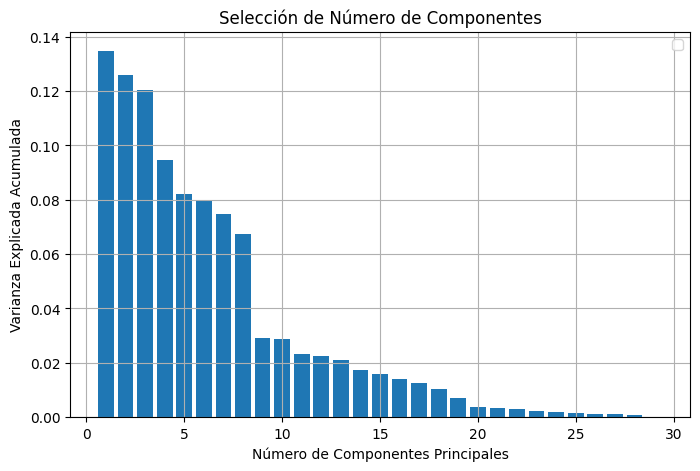

In [11]:
# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), pca.explained_variance_ratio_)
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Selección de Número de Componentes')
plt.legend(loc='best')
plt.grid()
plt.show()

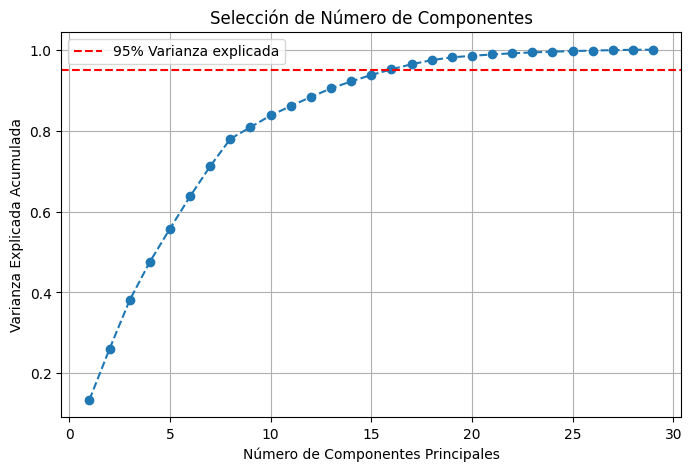

In [12]:
# Graficar la varianza explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Selección de Número de Componentes')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza explicada')  # Línea guía para el 95%
plt.legend(loc='best')
plt.grid()
plt.show()

In [13]:
# Ajustar PCA con 19 componentes principales
pca = PCA(n_components=19)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Generamos un diccionario con los conjuntos de datos resultantes

In [19]:
# Configurar los conjuntos de datos
datasets = {
    "X_train": X_train,
    "X_train_MI": X_train_MI,
    "X_train_pca": X_train_pca,
    "X_train_vif": X_train_vif
}

In [20]:
# Conjunto de prueba asociado
X_test_datasets = {
    "X_train": X_test,
    "X_train_MI": X_test_MI,
    "X_train_pca": X_test_pca,
    "X_train_vif": X_test_vif
}

# MODELADO

## APRENDIZAJE SUPERVISADO

### SVM

### RANDOM FOREST

In [ ]:
# Definir los hiperparámetros para el Grid Search
param_grid = {
    'estimator__n_estimators': [50, 100, 200],  # Número de árboles
    'random_forest__max_depth': [None, 10, 20],    # Profundidad máxima de los árboles
    'random_forest__min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'random_forest__min_samples_leaf': [1, 2, 4],    # Número mínimo de muestras por hoja
}

In [14]:
# Configurar los conjuntos de datos
datasets = {
    "X_train": X_train,
    "X_train_pca": X_train_pca
}

# Conjunto de prueba asociado
X_test_datasets = {
    "X_train": X_test,
    "X_train_pca": X_test_pca
}

In [64]:
# Definir los hiperparámetros para el Grid Search
param_grid = {
    'n_estimators': [50],  # Número de árboles
    'max_depth': [10],    # Profundidad máxima de los árboles
    'min_samples_split': [2],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1],    # Número mínimo de muestras por hoja
}

# Diccionario para almacenar los resultados
fpr = {}
tpr = {}
thresholds = {}
predicciones_binarias = {}

for name, X_train_set in datasets.items():


    classifier = RandomForestClassifier()
    # Crea el objeto GridSearchCV
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring='roc_auc',  
        cv=3  # Número de particiones en la validación cruzada
    )
    # entrenar el clasificador
    grid_search.fit(X_train_set, Y_train)

    # mostrar mejores parámetros
    print("Mejores hiperparámetros:", grid_search.best_params_)

    # Obtiene las mejores predicciones usando el modelo ajustado
    mejor_modelo = grid_search.best_estimator_

    X_test_set = X_test_datasets[name]
    predicciones = mejor_modelo.predict_proba(X_test_set)[:, 1]


    fpr[name], tpr[name], thresholds[name] = roc_curve(Y_test, predicciones)
    optimal_idx = np.argmax(tpr[name] - fpr[name])
    optimal_threshold = thresholds[name][optimal_idx]
    predicciones_binarias[name] = (predicciones > optimal_threshold).astype(int)




Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### MULTILAYER PERCEPTRON

In [ ]:
#1.- Definir MLP: capa entrada, capas ocultas y capa de salida
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation=None, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  
model.add(Dense(32, activation=None, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  
model.add(Dense(32, activation=None, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  
model.add(Dense(32, activation=None, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  
model.add(Dense(16, activation=None, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization()) 

model.add(Dense(1, activation='sigmoid'))


In [ ]:

initial_learning_rate = 0.001  # Tasa de aprendizaje inicial
decay_steps = 1000             # Número de pasos antes de reducir
decay_rate = 0.96              # Factor de reducción (96% del valor anterior)

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # Si es True, la tasa de aprendizaje cambia de manera escalonada
)

# Crear el optimizador Adam con el scheduler
adam = Adam(learning_rate=lr_schedule)

#2.- Compilar modelo usando optimizador con tasa de aprendizaje con decaimiento exponencial
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [ ]:
#3.- Entrenar el modelo
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

In [ ]:
#4.- Evaluar el modelo
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas 0 o 1


## APRENDIZAJE NO SUPERVISADO

## DBSCAN

In [15]:
from sklearn.cluster import DBSCAN

In [1]:
# Paso 3: Aplicar DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10, n_jobs = -1)  # Ajusta estos parámetros según sea necesario
labels = dbscan.fit_predict(X_test_pca)

NameError: name 'DBSCAN' is not defined

## AUTOENCODERS

## GAN (GENERATIVE ADVERSARIAL NETWORK)